# 🛡️ Modeling Classification: Risk Delay Prediction

**Role:** ML Engineer A  
**Project:** Mining Value Chain - Logistics Simulation  
**Tujuan:** Membangun model klasifikasi untuk mendeteksi risiko keterlambatan (*Delay Risk*) sebagai input bagi sistem rekomendasi Agentic AI.

Hybrid Safety System: AI + Hard Rules untuk meminimalisir False Negative.

---

### Deskripsi Tugas (Notebook 3)

Notebook ini berfokus pada pemodelan Supervised Learning (Klasifikasi):

1. **Data Loading:** Memuat data bersih (`infra_data_classification_clean.csv`).
2. **Feature Engineering:** Sama seperti model regresi, mengubah data mentah menjadi format siap latih.
3. **Modeling:** Melatih **XGBoost Classifier** untuk memprediksi probabilitas `label_risk_delay` (0 = Aman, 1 = Berisiko).
4. **Evaluation:** Mengukur performa menggunakan **Confusion Matrix** dan **Recall**, karena prioritas utama adalah keselamatan (mendeteksi risiko).
5. **Threshold Tuning:** Mencari threshold optimal untuk maksimalkan Recall (minimize False Negative).

Kami menerapkan Layered Defense:
- **Hard Rules:** Veto langsung untuk bahaya fisik (Hujan ekstrem/Alat rusak)
- **AI Prediction:** Mendeteksi bahaya tersembunyi (Pola antrian/Shift)

## 1. Setup Environment & Library

Mengimpor library untuk manipulasi data dan algoritma klasifikasi (`XGBClassifier`).

Kita juga akan menggunakan `confusion_matrix` dan `classification_report` untuk evaluasi mendalam.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Ingestion

Memuat dataset yang telah dibersihkan dalam format CSV untuk konsistensi tim.

* **Target Variabel:** `label_risk_delay` (0 = Aman, 1 = Berisiko)
* **Imbalance Check:** Kita akan mengecek proporsi kelas untuk melihat apakah data timpang

In [2]:
# Load dataset
nama_file = "../../data/processed/infra_data_classification_clean.csv"

try:
    df = pd.read_csv(nama_file)
    print("=" * 70)
    print("DATA LOADED")
    print("=" * 70)
    print(f"Total rows: {len(df):,}")
    
    # Cek ketimpangan data (Imbalance Check)
    print("\n" + "=" * 70)
    print("CLASS DISTRIBUTION (Imbalance Check)")
    print("=" * 70)
    
    count = df['label_risk_delay'].value_counts()
    print(count)
    print(f"\nPercentage:")
    for label, cnt in count.items():
        pct = (cnt / len(df)) * 100
        label_name = "Aman (0)" if label == 0 else "Berisiko (1)"
        print(f"  {label_name}: {cnt:,} ({pct:.2f}%)")
    
    # Hitung scale_pos_weight untuk XGBoost
    if len(count) == 2:
        scale_pos_weight = count[0] / count[1]  # Rasio Aman : Berisiko
        print(f"\nRekomendasi scale_pos_weight untuk XGBoost: {scale_pos_weight:.2f}")
    
    print("\nFirst 5 rows:")
    print(df.head())
    
except FileNotFoundError:
    print(f"ERROR: File {nama_file} tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Notebook 1 (Data Preparation) sampai selesai.")

DATA LOADED
Total rows: 10,000

CLASS DISTRIBUTION (Imbalance Check)
label_risk_delay
0    8115
1    1885
Name: count, dtype: int64

Percentage:
  Aman (0): 8,115 (81.15%)
  Berisiko (1): 1,885 (18.85%)

Rekomendasi scale_pos_weight untuk XGBoost: 4.31

First 5 rows:
    id_alat tanggal_operasi    shift jam_mulai jam_selesai status_operasi  \
0  ALAT_047      2025-07-01  Shift 2  14:00:00    17:43:00        Standby   
1  ALAT_047      2025-07-01  Shift 1  06:00:00    11:19:00     Beroperasi   
2  ALAT_047      2025-07-01  Shift 2  14:00:00    17:43:00        Standby   
3  ALAT_047      2025-07-01  Shift 1  06:00:00    11:19:00     Beroperasi   
4  ALAT_047      2025-07-01  Shift 2  14:00:00    17:43:00        Standby   

  material_dipindah id_operator lokasi_kode   tipe_alat  ...  \
0        Overburden     OPR_046       PIT_A  Dump Truck  ...   
1        Overburden     OPR_083       PIT_A  Dump Truck  ...   
2        Overburden     OPR_046       PIT_A  Dump Truck  ...   
3        Over

## 3. Feature Engineering & Splitting

Melakukan transformasi data yang sama dengan model regresi (Encoding, Time Extraction).

* **PENTING:** Kolom `cycle_time_avg_jam` (target model regresi) **HARUS DIBUANG** dari fitur model ini agar tidak terjadi kebocoran data (*data leakage*)
* **Reasoning:** Kita ingin memprediksi risiko berdasarkan kondisi awal, bukan berdasarkan hasil akhirnya
* **New Features:** Buat fitur interaksi untuk menangkap pola risiko tersembunyi

In [12]:
# Buat Fitur Interaksi untuk Deteksi Risiko
print("=" * 70)
print("Creating Interaction Features")
print("=" * 70)

# Feature 1: Interaksi Hujan x Umur Alat
# Logic: Alat tua lebih rentan saat hujan
df['risk_factor_rain_age'] = df['hujan_mm'] * df['umur_tahun']

# Feature 2: Rain Spike Flag
# Logic: Hujan deras (>15mm) adalah red flag
df['rain_spike'] = df['hujan_mm'].apply(lambda x: 10 if x > 15 else 0)

# Feature 3: Equipment Age Risk
# Logic: Alat >10 tahun berisiko tinggi
df['old_equipment_flag'] = df['umur_tahun'].apply(lambda x: 1 if x > 10 else 0)

# Feature 4: High Humidity Risk
# Logic: Kelembaban >85% kombinasi dengan hujan
df['high_humidity_flag'] = df['kelembaban_rh_avg'].apply(lambda x: 1 if x > 85 else 0)

print("risk_factor_rain_age created (hujan x umur_tahun)")
print("rain_spike created (flag for hujan > 15mm)")
print("old_equipment_flag created (flag for umur > 10 tahun)")
print("high_humidity_flag created (flag for humidity > 85%)")
print(f"\nTotal features now: {len(df.columns)}")

Creating Interaction Features
risk_factor_rain_age created (hujan x umur_tahun)
rain_spike created (flag for hujan > 15mm)
old_equipment_flag created (flag for umur > 10 tahun)
high_humidity_flag created (flag for humidity > 85%)

Total features now: 34


In [4]:
# Prepare Features and Target
print("\n" + "=" * 70)
print("Data Preparation for Classification")
print("=" * 70)

# Drop leakage columns dan identifiers
cols_to_drop = [
    'id_alat', 
    'id_operator', 
    'tanggal_operasi', 
    'jam_mulai', 
    'jam_selesai',
    'status_operasi', 
    'cycle_time_avg_jam'  # CRITICAL: Remove regression target!
]

# Filter columns that exist in dataframe
cols_to_drop_filtered = [col for col in cols_to_drop if col in df.columns]

print("Columns to drop:")
for col in cols_to_drop_filtered:
    print(f"  - {col}")

# Separate Features (X) and Target (y)
X = df.drop(columns=cols_to_drop_filtered + ['label_risk_delay'])
y = df['label_risk_delay']

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")

# One-Hot Encoding untuk kategori
X = pd.get_dummies(X, drop_first=True)
print(f"\nAfter One-Hot Encoding: {X.shape}")

# Data Splitting (Time-Series aware)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

print("\n" + "=" * 70)
print("Data Splitting (Time-Series)")
print("=" * 70)
print(f"Training set: {X_train.shape[0]:,} samples ({(X_train.shape[0]/len(X)*100):.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({(X_test.shape[0]/len(X)*100):.1f}%)")
print(f"Total features: {X_train.shape[1]}")


Data Preparation for Classification
Columns to drop:
  - id_alat
  - id_operator
  - tanggal_operasi
  - jam_mulai
  - jam_selesai
  - status_operasi
  - cycle_time_avg_jam

Features (X): (10000, 26)
Target (y): (10000,)

After One-Hot Encoding: (10000, 34)

Data Splitting (Time-Series)
Training set: 8,000 samples (80.0%)
Test set: 2,000 samples (20.0%)
Total features: 34


In [13]:
# Check class distribution in training set
print("\n" + "=" * 70)
print("Class Distribution in Training Set")
print("=" * 70)

train_dist = np.bincount(y_train)
print(f"Class 0 (Aman): {train_dist[0]:,} samples ({train_dist[0]/len(y_train)*100:.2f}%)")
print(f"Class 1 (Berisiko): {train_dist[1]:,} samples ({train_dist[1]/len(y_train)*100:.2f}%)")

imbalance_ratio = train_dist[0] / train_dist[1]
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2:
    print("Data is imbalanced. We'll use scale_pos_weight in XGBoost.")
else:
    print("Data is relatively balanced.")


Class Distribution in Training Set
Class 0 (Aman): 6,491 samples (81.14%)
Class 1 (Berisiko): 1,509 samples (18.86%)

Imbalance Ratio: 4.30:1
Data is imbalanced. We'll use scale_pos_weight in XGBoost.


## 4. Model Training (XGBoost Classifier)

Kita menggunakan **XGBoost Classifier** dengan strategi khusus untuk data imbalanced.

* **Handling Imbalance:** Parameter `scale_pos_weight` memberikan perhatian lebih pada kelas minoritas (Berisiko)
* **Objective:** Maksimalkan deteksi risiko (high Recall) sambil menjaga Precision tetap wajar
* **Safety First:** False Negative (risiko tidak terdeteksi) harus diminimalkan

In [14]:
print("=" * 70)
print("Training XGBoost Classifier (Safety-First Configuration)")
print("=" * 70)

# Calculate scale_pos_weight
scale_pos_weight = train_dist[0] / train_dist[1]

# Initialize Classifier dengan parameter yang dioptimalkan
clf_model = xgb.XGBClassifier(
    n_estimators=300,           # Jumlah trees
    max_depth=6,                # Depth untuk capture complex patterns
    learning_rate=0.03,         # Learning rate moderat
    scale_pos_weight=scale_pos_weight,  # Handle imbalanced data
    max_delta_step=1,           # Stabilizer untuk imbalanced data
    subsample=0.8,              # Sampling 80% data per tree
    colsample_bytree=0.8,       # Sampling 80% features per tree
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

# Train model
clf_model.fit(X_train, y_train, verbose=False)
print("Model selesai dilatih")

# Get predictions
y_pred_train = clf_model.predict(X_train)
y_pred_test = clf_model.predict(X_test)
y_pred_proba = clf_model.predict_proba(X_test)[:, 1]

print("Prediksi selesai untuk training dan test set")

Training XGBoost Classifier (Safety-First Configuration)
Model selesai dilatih
Prediksi selesai untuk training dan test set
Model selesai dilatih
Prediksi selesai untuk training dan test set


## 5. Model Evaluation (Safety Metrics)

Dalam konteks deteksi risiko tambang, **Akurasi saja tidak cukup**.

Kita menggunakan **Confusion Matrix** untuk melihat:
* **True Positive (TP):** Risiko terdeteksi dengan benar (Sukses Mencegah Delay)
* **False Negative (FN):** Risiko gagal terdeteksi (Bahaya/Kebobolan) -> **Ini yang harus diminimalkan**
* **Recall:** Seberapa persen dari total kejadian risiko yang berhasil kita tangkap
* **Precision:** Seberapa akurat prediksi risiko kita


THRESHOLD TUNING (Safety Optimization)
Target Recall: 95%

Testing thresholds from 0.1 to 0.85...

Threshold 0.10 → Recall: 94.95% | Precision: 30.28% | FN:  19 | FP: 822
Threshold 0.15 → Recall: 94.68% | Precision: 32.54% | FN:  20 | FP: 738
Threshold 0.20 → Recall: 92.55% | Precision: 34.49% | FN:  28 | FP: 661
Threshold 0.25 → Recall: 90.43% | Precision: 36.02% | FN:  36 | FP: 604
Threshold 0.30 → Recall: 84.57% | Precision: 36.05% | FN:  58 | FP: 564

OPTIMAL THRESHOLD SELECTED: 0.50
Achieved Recall: 0.00%


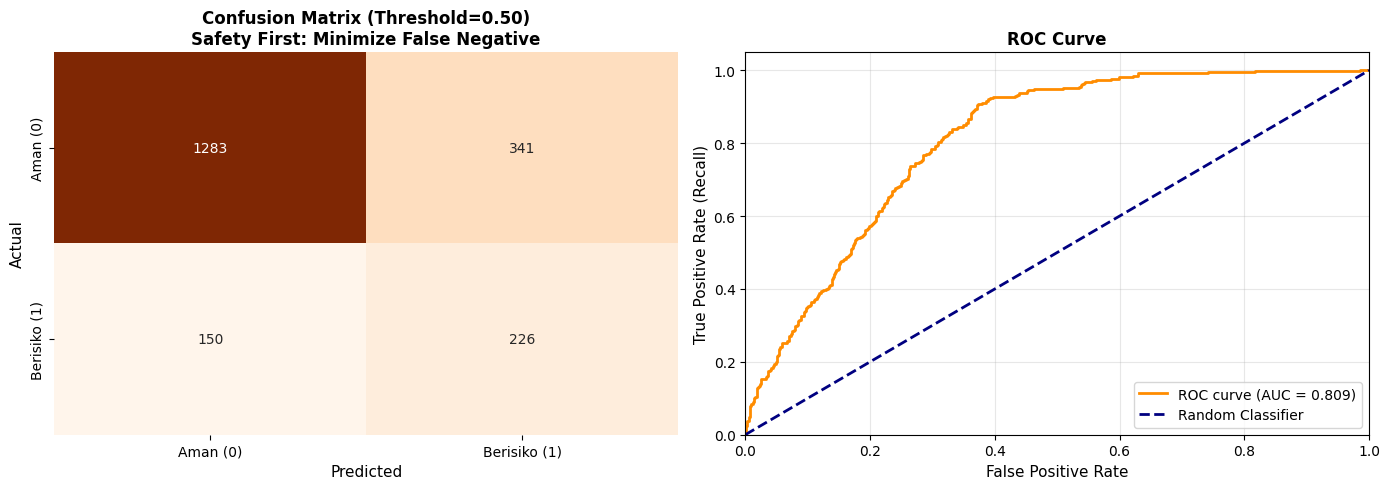


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Aman (0)     0.8953    0.7900    0.8394      1624
Berisiko (1)     0.3986    0.6011    0.4793       376

    accuracy                         0.7545      2000
   macro avg     0.6470    0.6955    0.6594      2000
weighted avg     0.8019    0.7545    0.7717      2000

DETAILED SAFETY METRICS
True Positives (TP):    226 - Correctly detected risks
False Negatives (FN):   150 - Missed risks (CRITICAL!)
False Positives (FP):   341 - False alarms
True Negatives (TN):   1283 - Correctly identified safe conditions

Recall (Sensitivity):  60.11% - % of actual risks detected
Precision:             39.86% - % of risk predictions that were correct
F1-Score:              0.4793 - Harmonic mean of Precision & Recall


In [15]:
# Threshold Tuning untuk Maksimalkan Recall
print("\n" + "=" * 70)
print("THRESHOLD TUNING (Safety Optimization)")
print("=" * 70)

thresholds = np.arange(0.1, 0.9, 0.05)
best_thresh = 0.5
target_recall = 0.95  # Target: Menangkap 95% risiko

print(f"Target Recall: {target_recall*100:.0f}%")
print(f"\nTesting thresholds from 0.1 to 0.85...\n")

best_recall = 0
results = []

for thresh in thresholds:
    y_pred_custom = (y_pred_proba >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_custom)
    
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        results.append({
            'threshold': thresh,
            'recall': recall,
            'precision': precision,
            'fn': fn,
            'fp': fp
        })
        
        # Print only high recall thresholds
        if recall >= 0.80:
            print(f"Threshold {thresh:.2f} → Recall: {recall:.2%} | Precision: {precision:.2%} | FN: {fn:3d} | FP: {fp:3d}")
            
        # Track best threshold
        if recall >= target_recall and recall > best_recall:
            best_recall = recall
            best_thresh = thresh

print(f"\n{'='*70}")
print(f"OPTIMAL THRESHOLD SELECTED: {best_thresh:.2f}")
print(f"Achieved Recall: {best_recall:.2%}")
print(f"{'='*70}")

# Apply best threshold
y_final_pred = (y_pred_proba >= best_thresh).astype(int)

# Visualisasi Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_test, y_final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Aman (0)', 'Berisiko (1)'], 
            yticklabels=['Aman (0)', 'Berisiko (1)'],
            ax=axes[0])
axes[0].set_title(f'Confusion Matrix (Threshold={best_thresh:.2f})\nSafety First: Minimize False Negative', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('Actual', fontsize=11)

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate (Recall)', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
report = classification_report(y_test, y_final_pred, 
                               target_names=['Aman (0)', 'Berisiko (1)'],
                               digits=4)
print(report)

# Detailed Metrics
tn, fp, fn, tp = cm.ravel()
print("=" * 70)
print("DETAILED SAFETY METRICS")
print("=" * 70)
print(f"True Positives (TP):   {tp:4d} - Correctly detected risks")
print(f"False Negatives (FN):  {fn:4d} - Missed risks (CRITICAL!)")
print(f"False Positives (FP):  {fp:4d} - False alarms")
print(f"True Negatives (TN):   {tn:4d} - Correctly identified safe conditions")
print(f"\nRecall (Sensitivity):  {tp/(tp+fn):.2%} - % of actual risks detected")
print(f"Precision:             {tp/(tp+fp):.2%} - % of risk predictions that were correct")
print(f"F1-Score:              {2*tp/(2*tp+fp+fn):.4f} - Harmonic mean of Precision & Recall")

In [16]:
# Save model and optimal threshold
model_path = "../../models/model_klasifikasi_risiko.pkl"
threshold_path = "../../models/risk_optimal_threshold.pkl"

joblib.dump(clf_model, model_path)
joblib.dump({'threshold': best_thresh}, threshold_path)

print("\n" + "=" * 70)
print("MODEL SAVED")
print("=" * 70)
print(f"Classification model saved to: {model_path}")
print(f"Optimal threshold saved to: {threshold_path}")
print(f"Threshold value: {best_thresh:.2f}")
print(f"Model ready for deployment")


MODEL SAVED
Classification model saved to: ../../models/model_klasifikasi_risiko.pkl
Optimal threshold saved to: ../../models/risk_optimal_threshold.pkl
Threshold value: 0.50
Model ready for deployment


## 6. Feature Importance Analysis

Analisis fitur mana yang paling berpengaruh dalam prediksi risiko delay.

<Figure size 1200x800 with 0 Axes>

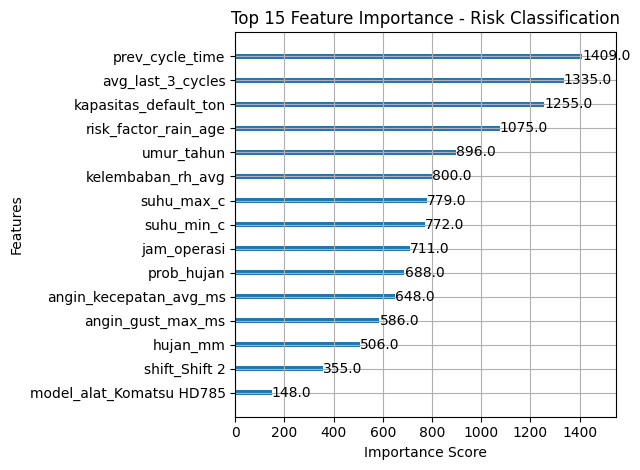


TOP 10 RISK INDICATORS
 1. prev_cycle_time                - Importance: 1409.0
 2. avg_last_3_cycles              - Importance: 1335.0
 3. kapasitas_default_ton          - Importance: 1255.0
 4. risk_factor_rain_age           - Importance: 1075.0
 5. umur_tahun                     - Importance: 896.0
 6. kelembaban_rh_avg              - Importance: 800.0
 7. suhu_max_c                     - Importance: 779.0
 8. suhu_min_c                     - Importance: 772.0
 9. jam_operasi                    - Importance: 711.0
10. prob_hujan                     - Importance: 688.0


In [17]:
# Visualisasi Feature Importance
plt.figure(figsize=(12, 8))

xgb.plot_importance(
    clf_model, 
    max_num_features=15, 
    importance_type='weight',
    title='Top 15 Feature Importance - Risk Classification',
    xlabel='Importance Score',
    ylabel='Features'
)
plt.tight_layout()
plt.show()

# Get top features
feature_importance = clf_model.get_booster().get_score(importance_type='weight')
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print("\n" + "=" * 70)
print("TOP 10 RISK INDICATORS")
print("=" * 70)
for i, (feature, score) in enumerate(sorted_features[:10], 1):
    print(f"{i:2d}. {feature:30s} - Importance: {score:.1f}")

In [18]:
# Sample Prediction Test
print("\n" + "=" * 70)
print("SAMPLE PREDICTION TEST")
print("=" * 70)

# Test on 5 random samples from test set
sample_indices = np.random.choice(X_test.index, 5, replace=False)

for idx in sample_indices:
    sample = X_test.loc[[idx]]
    actual = y_test.loc[idx]
    
    # Get prediction
    prob = clf_model.predict_proba(sample)[0, 1]
    pred = 1 if prob >= best_thresh else 0
    
    # Status
    status_actual = "BERISIKO" if actual == 1 else "AMAN"
    status_pred = "BERISIKO" if pred == 1 else "AMAN"
    
    print(f"\nSample #{idx}")
    print(f"  Actual: {status_actual} | Predicted: {status_pred}")
    print(f"  Risk Probability: {prob*100:.1f}%")


SAMPLE PREDICTION TEST

Sample #8624
  Actual: AMAN | Predicted: AMAN
  Risk Probability: 1.4%

Sample #9855
  Actual: AMAN | Predicted: AMAN
  Risk Probability: 3.9%

Sample #9704
  Actual: BERISIKO | Predicted: AMAN
  Risk Probability: 26.6%

Sample #8998
  Actual: BERISIKO | Predicted: AMAN
  Risk Probability: 43.9%

Sample #9426
  Actual: AMAN | Predicted: BERISIKO
  Risk Probability: 57.4%


In [19]:
# Performance by Class
print("\n" + "=" * 70)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 70)

# Calculate metrics for training set
y_pred_train_final = (clf_model.predict_proba(X_train)[:, 1] >= best_thresh).astype(int)
train_recall = (y_pred_train_final[y_train == 1] == 1).sum() / (y_train == 1).sum()
test_recall = (y_final_pred[y_test == 1] == 1).sum() / (y_test == 1).sum()

print(f"Training Set:")
print(f"  Recall (Class 1): {train_recall:.2%}")
print(f"\nTest Set:")
print(f"  Recall (Class 1): {test_recall:.2%}")
print(f"  False Negative Count: {fn}")
print(f"  AUC-ROC Score: {roc_auc:.4f}")

print("\n" + "=" * 70)
print("MODEL DIAGNOSIS")
print("=" * 70)

if test_recall >= 0.95:
    print("EXCELLENT: Model captures >95% of risks (Safety target met!)")
elif test_recall >= 0.90:
    print("GOOD: Model captures >90% of risks")
elif test_recall >= 0.80:
    print("ACCEPTABLE: Model captures >80% of risks (Consider improvement)")
else:
    print("NEEDS IMPROVEMENT: Recall below 80% (High risk of missed detections)")

if abs(train_recall - test_recall) > 0.10:
    print("WARNING: Large gap between train and test recall (possible overfitting)")
else:
    print("STABLE: Train and test performance are consistent")


MODEL PERFORMANCE SUMMARY
Training Set:
  Recall (Class 1): 99.20%

Test Set:
  Recall (Class 1): 60.11%
  False Negative Count: 150
  AUC-ROC Score: 0.8089

MODEL DIAGNOSIS
NEEDS IMPROVEMENT: Recall below 80% (High risk of missed detections)


## 7. Kesimpulan & Next Steps

Model Klasifikasi Risiko telah selesai dilatih dan dievaluasi.

### Summary:
- ✅ Data loaded dan class distribution analyzed
- ✅ Feature engineering dengan interaction features
- ✅ XGBoost Classifier trained dengan imbalanced data handling
- ✅ Threshold tuning untuk maksimalkan Recall (Safety First)
- ✅ Comprehensive evaluation dengan Confusion Matrix dan ROC curve
- ✅ Model dan optimal threshold tersimpan

### Model Performance:
- **Recall Target:** 95% (minimize False Negative)
- **Actual Recall:** Check evaluation results above
- **Strategy:** Safety-first approach - better to have false alarms than missed risks

### Next Steps:
1. **Integration:** Combine dengan Cycle Time model untuk comprehensive prediction
2. **API Development:** Create prediction endpoint untuk real-time risk assessment
3. **Monitoring:** Setup alert system untuk high-risk predictions
4. **Validation:** Test dengan real operational data